In [1]:
# import common lib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from visualize_util import *

In [2]:
# active seaborn theme for matplotlib
sns.set_theme()

1. Load dataset

In [3]:
df1 = pd.read_csv('./open-meteo.2000-2009.csv')
df2 = pd.read_csv('./open-meteo.2010-2019.csv')
df3 = pd.read_csv('./open-meteo.2020-2025.csv')

data = pd.concat([df1, df2, df3])

In [4]:
print(f"column count {data.columns.size}")
print(f"row count count {data.size}")
print(f"feature list: {data.columns}")
print("sample 1 row:")
print(data[0:1])

column count 56
row count count 525000
feature list: Index(['Unnamed: 0', 'date', 'weather_code', 'temperature_2m_mean',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_mean',
       'apparent_temperature_max', 'apparent_temperature_min', 'sunrise',
       'sunset', 'daylight_duration', 'sunshine_duration', 'precipitation_sum',
       'rain_sum', 'snowfall_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_gusts_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
       'cloud_cover_mean', 'cloud_cover_max', 'cloud_cover_min',
       'dew_point_2m_mean', 'dew_point_2m_max', 'dew_point_2m_min',
       'et0_fao_evapotranspiration_sum', 'relative_humidity_2m_mean',
       'relative_humidity_2m_max', 'relative_humidity_2m_min',
       'snowfall_water_equivalent_sum', 'pressure_msl_mean',
       'pressure_msl_max', 'pressure_msl_min', 'surface_pressure_mean',
       'surface_pressure_max', 'surface_pr

2. Preproccessing

In [5]:
# tháng chắc chắn có liên hệ với thời tiết, vì tháng thể hiện mùa
data['month'] = data['date'].str[5:7]
data['month'] = data['month'].astype(int)

# năm có thể có liên hệ với thời tiết, chẳng hạn biến đổi khí hậu
data['year'] = data['date'].str[:4]
data['year'] = data['year'].astype(int)

In [6]:
# drop 2 column index and date
data.drop(['Unnamed: 0', 'date'], axis=1, inplace=True)
# there is no snow fall in HCM city
data.drop(['snowfall_sum', 'snowfall_water_equivalent_sum'], axis=1, inplace=True)

In [7]:
# co le khong anh huong
data.drop(['sunrise', 'sunset'], axis=1, inplace=True)

In [8]:
# drop min max keep mean only
data.drop(['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max', 'apparent_temperature_min', 
           'wind_speed_10m_max', 'wind_gusts_10m_max', 'cloud_cover_max', 'cloud_cover_min', 'dew_point_2m_max',
           'dew_point_2m_min', 'relative_humidity_2m_max', 'relative_humidity_2m_min', 'pressure_msl_max', 'pressure_msl_min',
           'surface_pressure_max', 'surface_pressure_min', 'wind_gusts_10m_min', 'wind_speed_10m_min', 
           'wet_bulb_temperature_2m_max', 'wet_bulb_temperature_2m_min'], axis=1, inplace=True)

In [9]:
# weather_code được lưu dưới dạng float nhưng nó là mã code (về lý thuyết) do con người đặt giá trị
# (có thể code này được đặt tự động -> không rõ trong tập dữ liệu này)
data['weather_code'] = data['weather_code'].astype(int)

In [10]:
# check if there is missing value
# All zero is good
print(data.isnull().sum())

weather_code                         0
temperature_2m_mean                  0
apparent_temperature_mean            0
daylight_duration                    0
sunshine_duration                    0
precipitation_sum                    0
rain_sum                             0
precipitation_hours                  0
wind_direction_10m_dominant          0
shortwave_radiation_sum              0
et0_fao_evapotranspiration           0
cloud_cover_mean                     0
dew_point_2m_mean                    0
et0_fao_evapotranspiration_sum       0
relative_humidity_2m_mean            0
pressure_msl_mean                    0
surface_pressure_mean                0
winddirection_10m_dominant           0
wind_gusts_10m_mean                  0
wind_speed_10m_mean                  0
wet_bulb_temperature_2m_mean         0
vapour_pressure_deficit_max          0
soil_moisture_0_to_100cm_mean        0
soil_moisture_0_to_7cm_mean          0
soil_moisture_28_to_100cm_mean       0
soil_moisture_7_to_28cm_m

In [11]:
data_len = len(data[data.columns[0]])
feature_len = data.columns.size - 1

print(data_len)
print(feature_len)

9375
31


In [12]:
data.columns[2]

'apparent_temperature_mean'

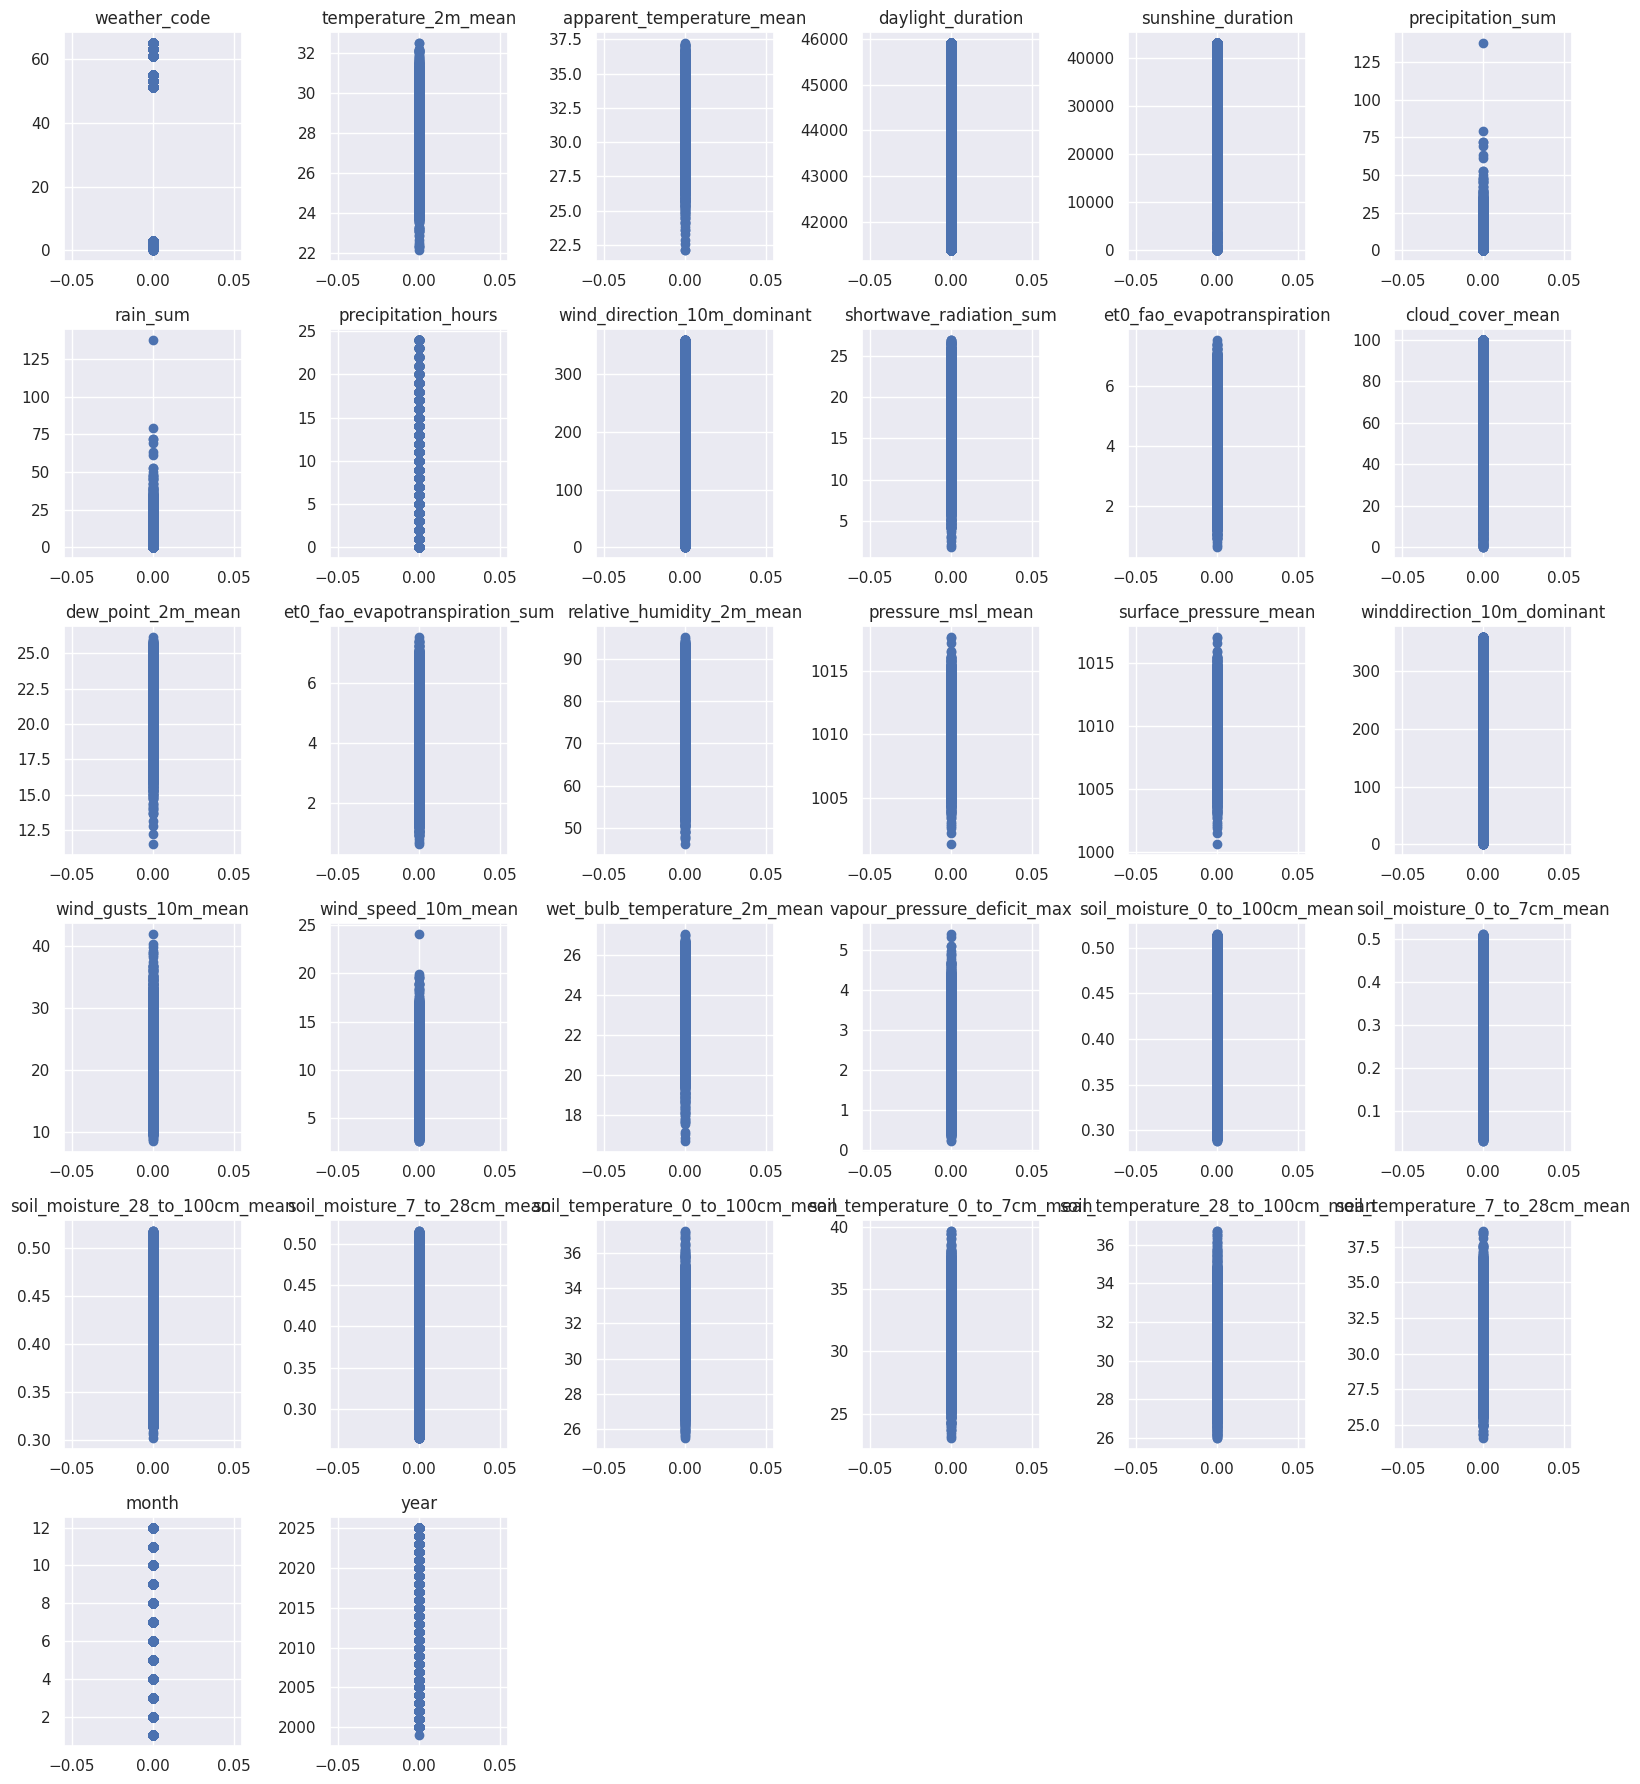

In [13]:
# Ứng với mỗi feature, vẽ tất cả các điểm
# Mục đích: nhanh chóng tìm các phần tử ngoại lai
visualize_each_feature_in_1D_vertical(data)

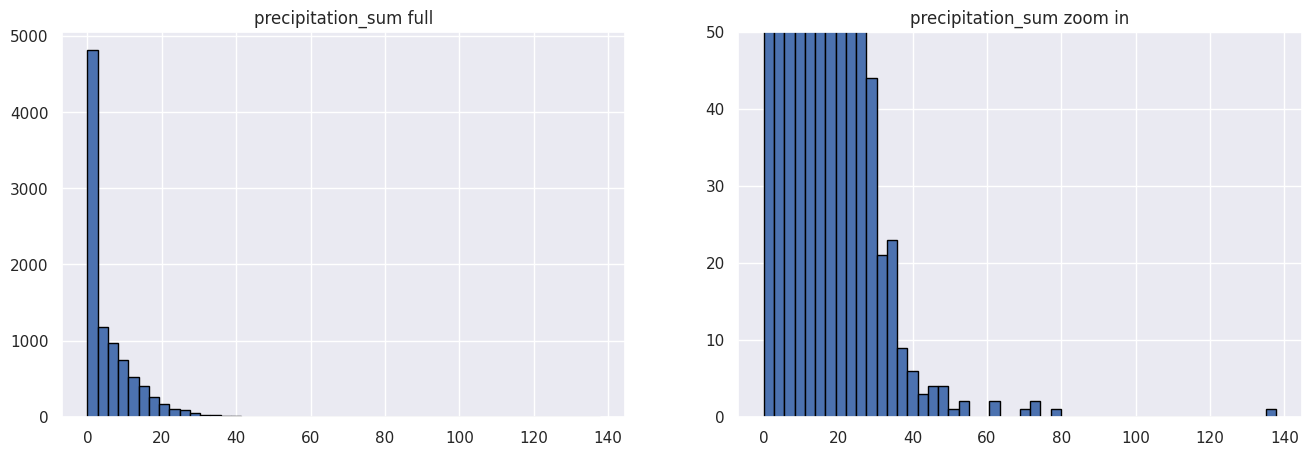

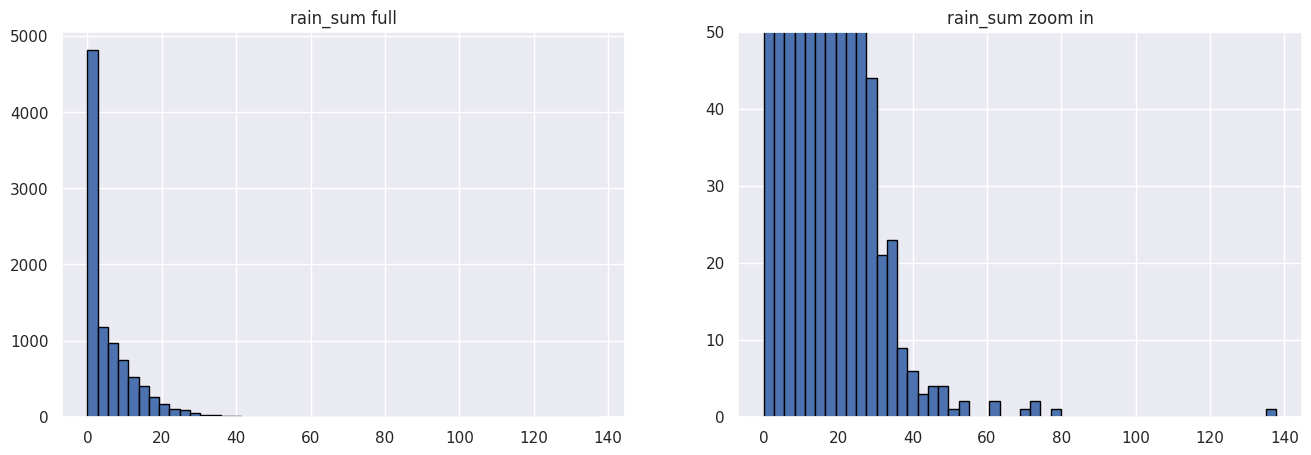

In [14]:
# Các feature nghi ngờ có outlier
inspect = ["precipitation_sum", "rain_sum"]

# Kiểm tra kỹ hơn bằng biểu đồ histogram
for i in range(len(inspect)):
    visualize_histogram_crop(data[inspect[i]], inspect[i], 0, 50)

Nhận xét
- Gần như toàn bộ dữ liệu có value dưới 80
- Xuất hiện phần tử có giá trị gần 140 với tỷ lệ xuất hiện cực kỳ thấp
- Trong 1 khoảng giữa cực lớn không xuất hiện điểm dữ liệu nào khác

Kết luận:
- precipitation_sum, rain_sum tồn tại outlier cần loại bỏ

Giải pháp:
- Thay giá trị outlier bằng median ?
- Xóa dòng có outlier ?                 <- chọn

In [15]:
# Xóa outlier

# Condition to remove
condition = (data['precipitation_sum'] > 100) | (data['rain_sum'] > 100)

# Get the index of rows satisfying the condition
rows_to_drop_index = data[condition].index

# Drop the rows
data.drop(rows_to_drop_index, inplace=True)

print(f"drop {len(rows_to_drop_index)} row")

drop 1 row


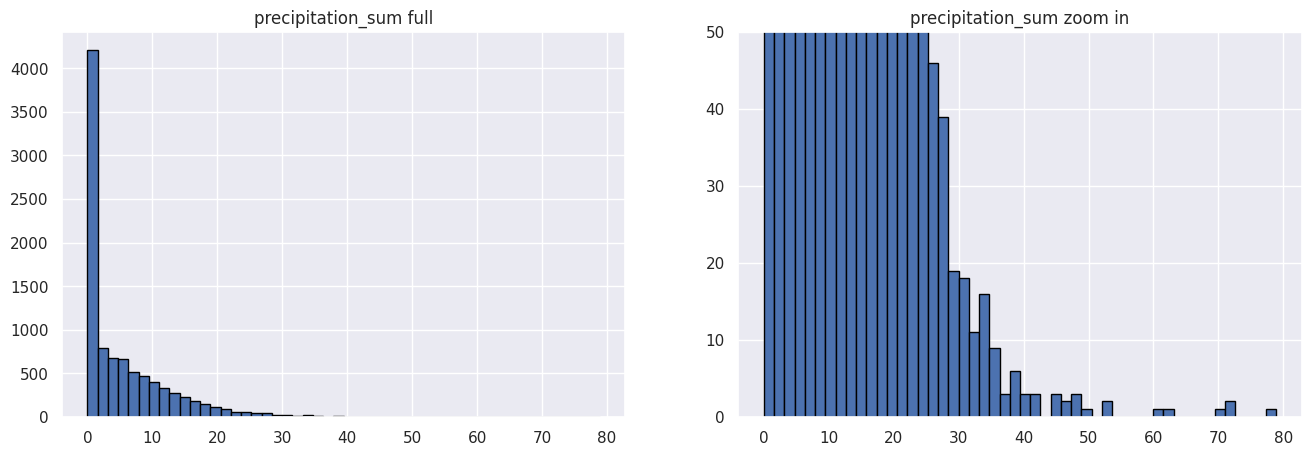

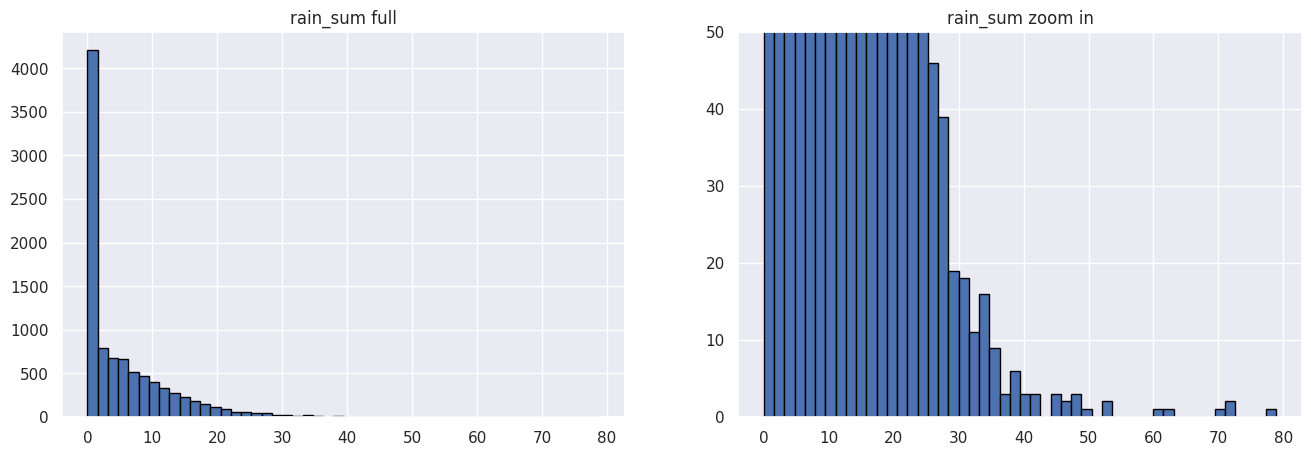

In [16]:
# Kiểm tra lại sau khi xử lý bằng biểu đồ histogram
for i in range(len(inspect)):
    visualize_histogram_crop(data[inspect[i]], inspect[i], 0, 50)

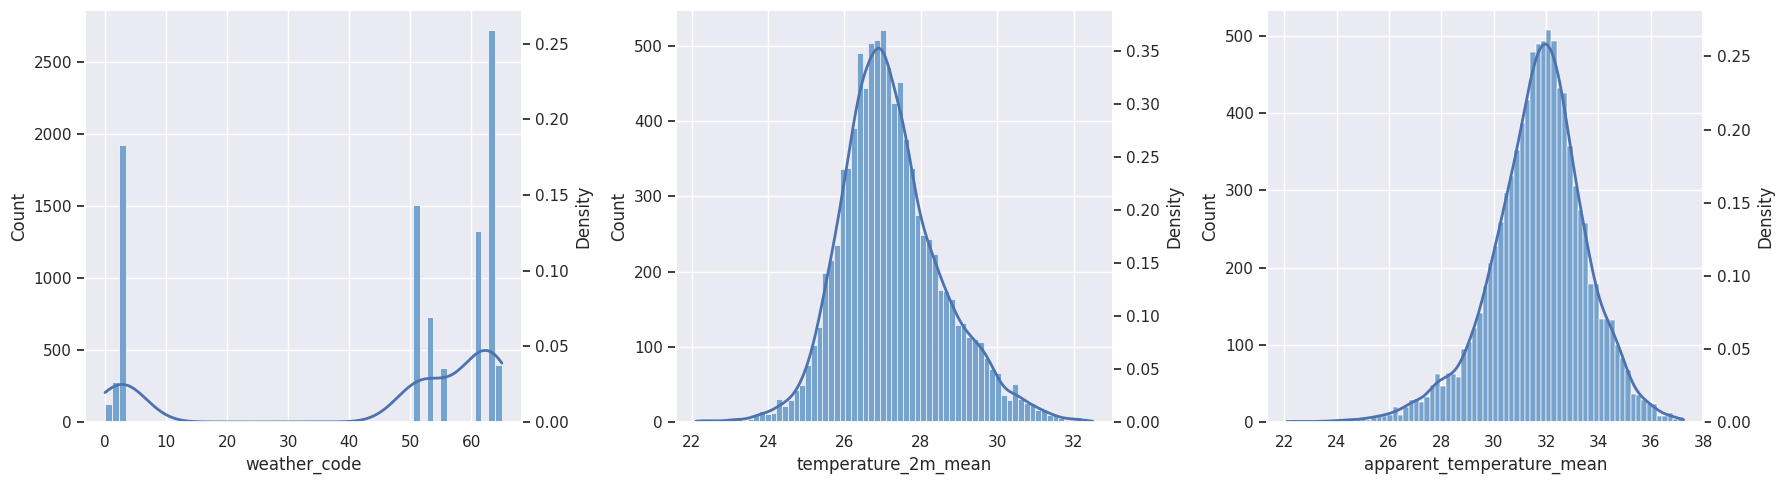

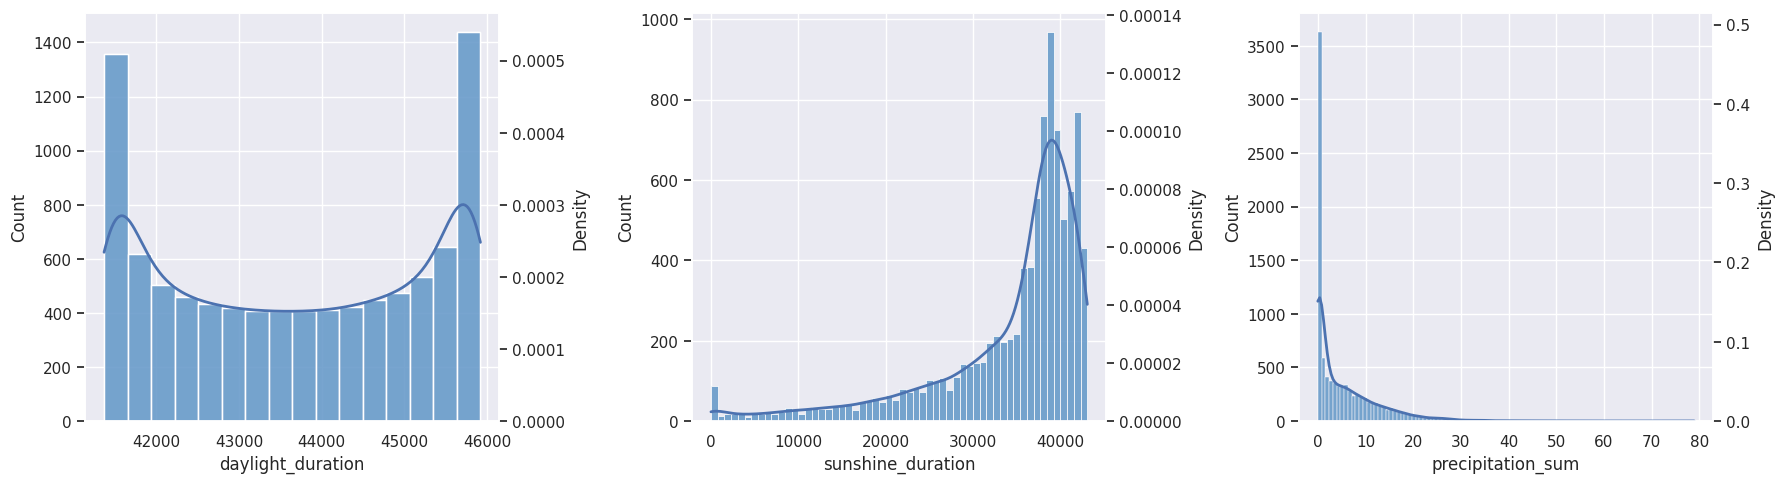

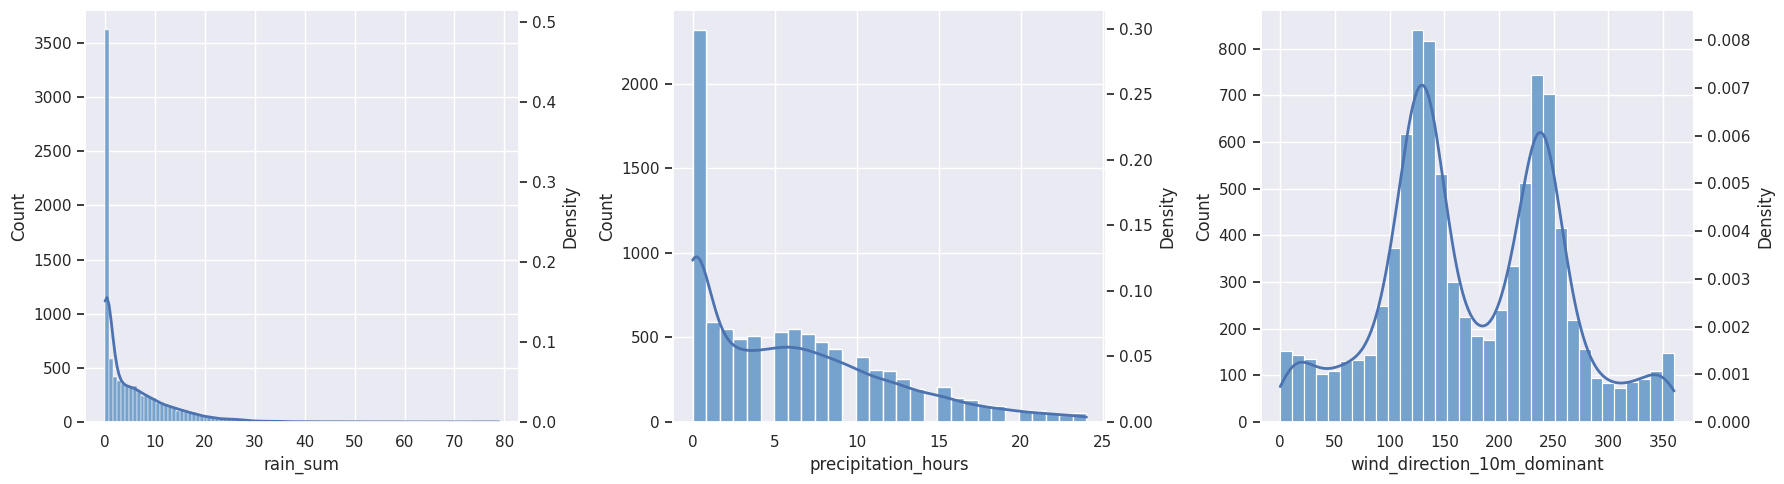

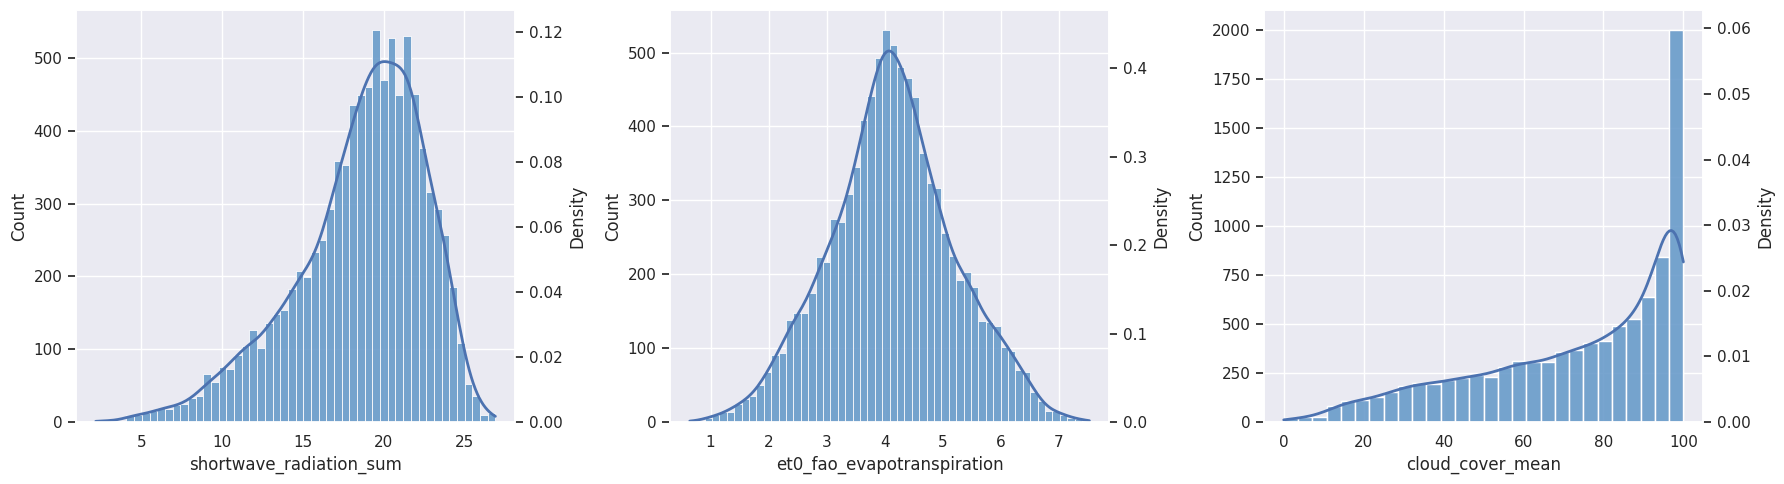

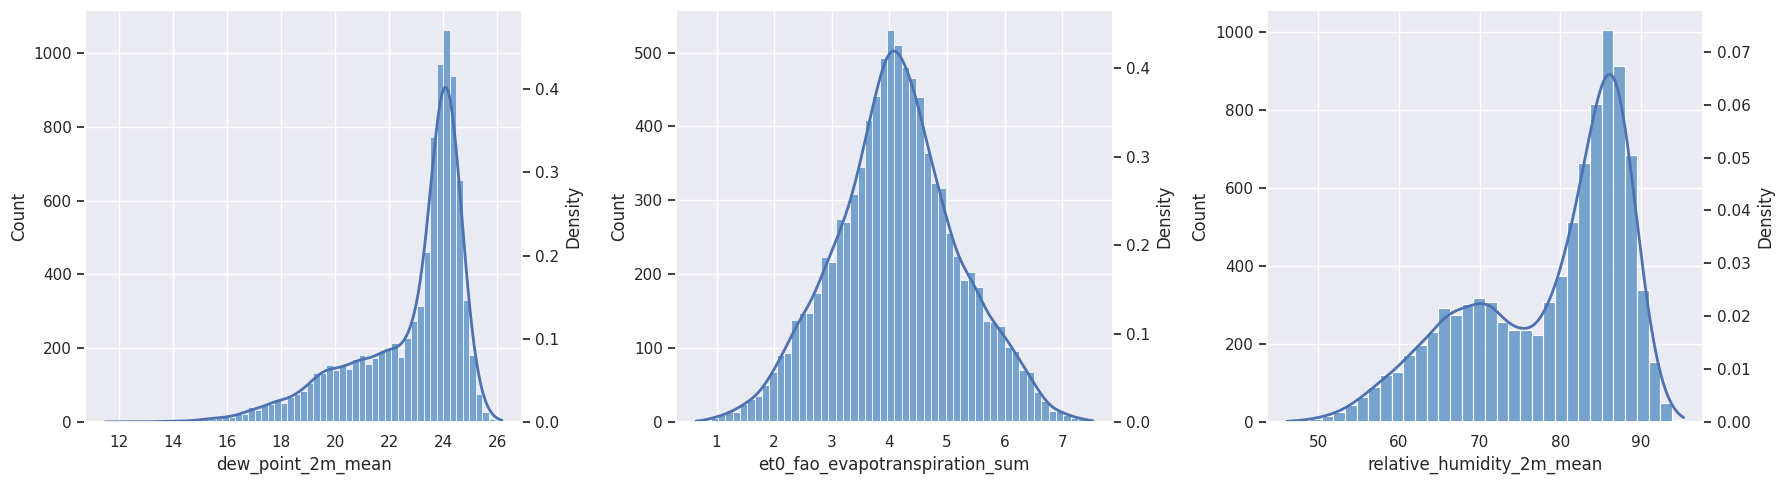

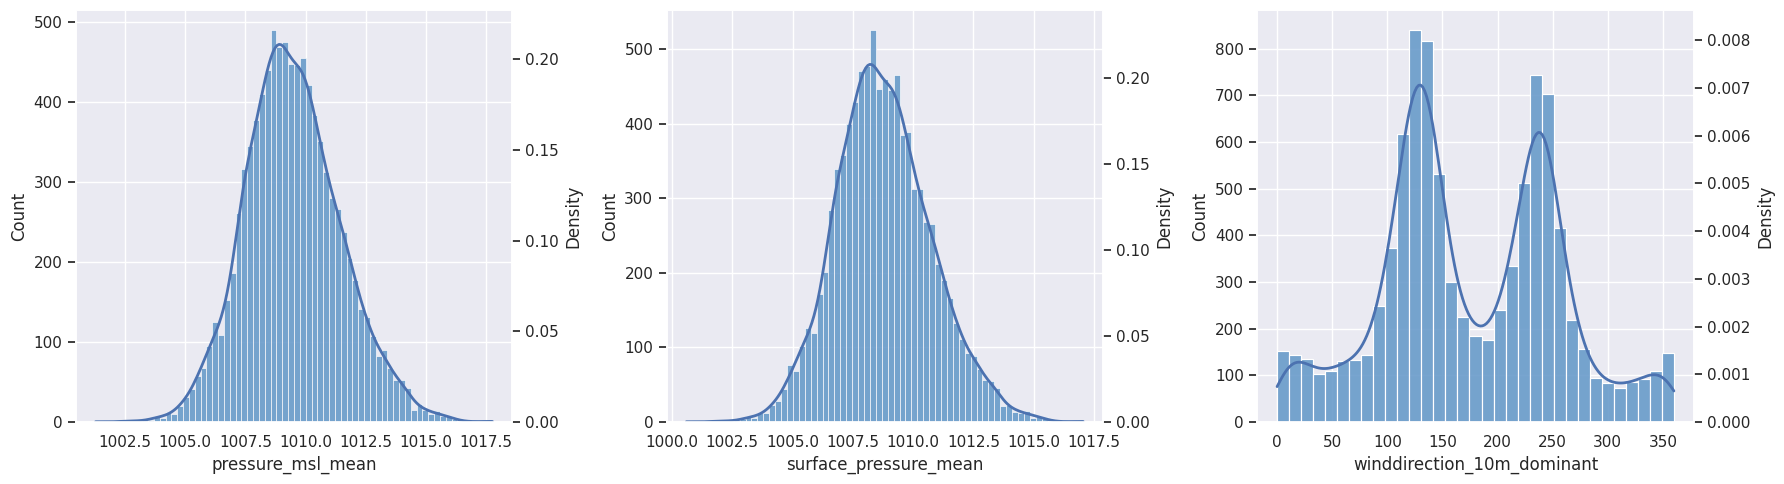

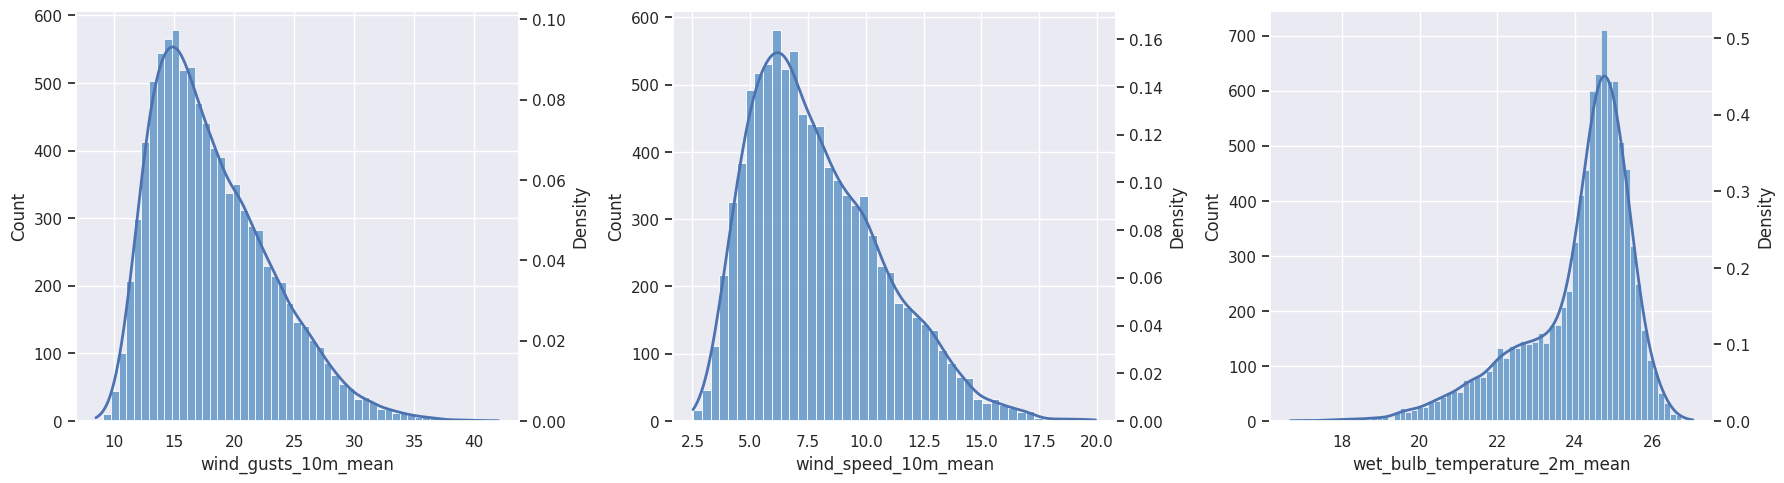

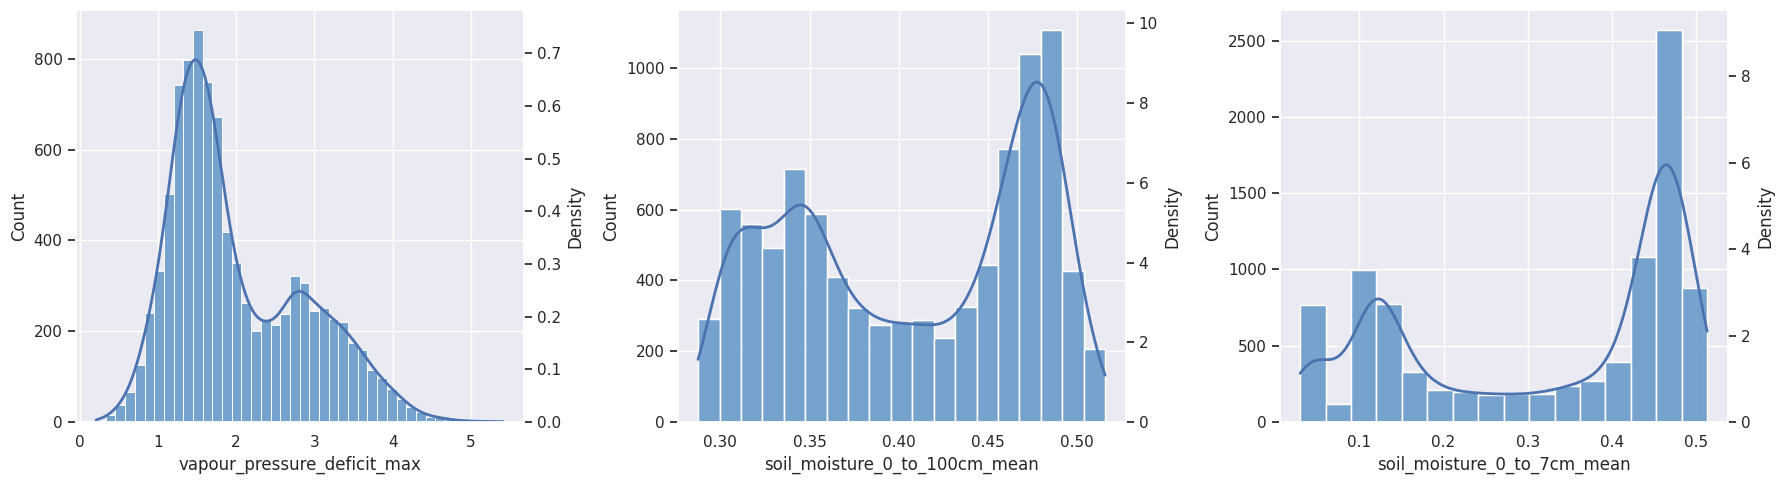

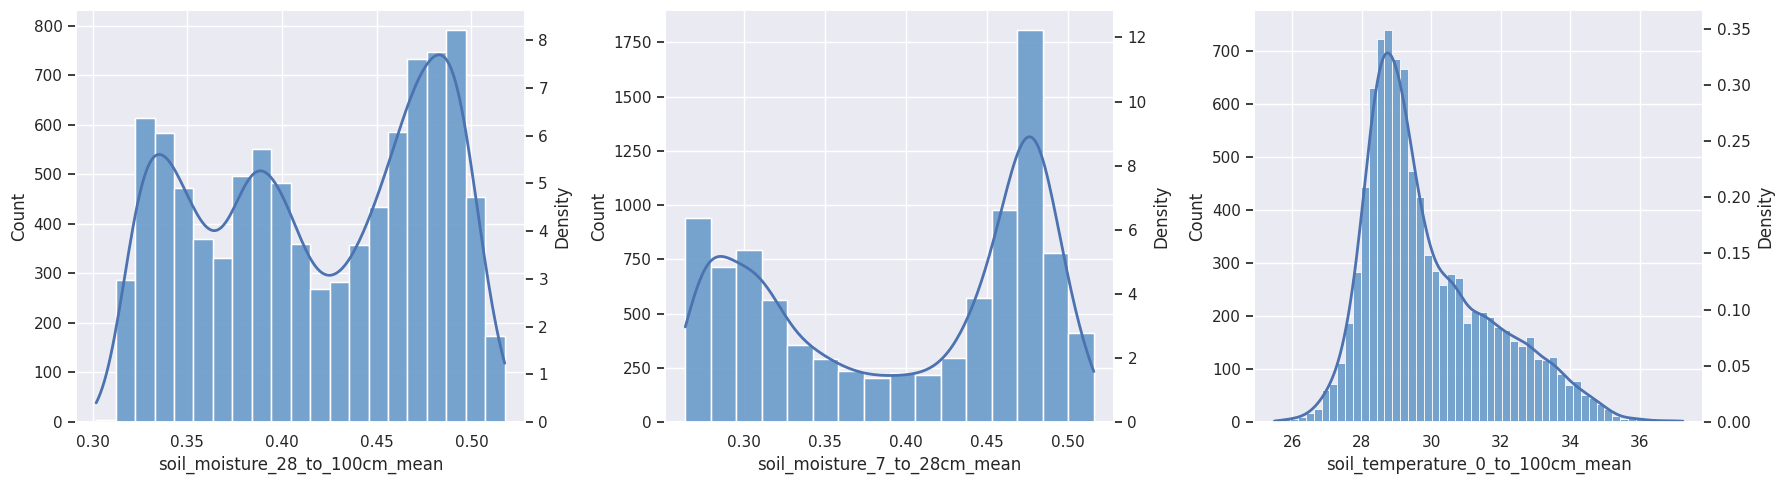

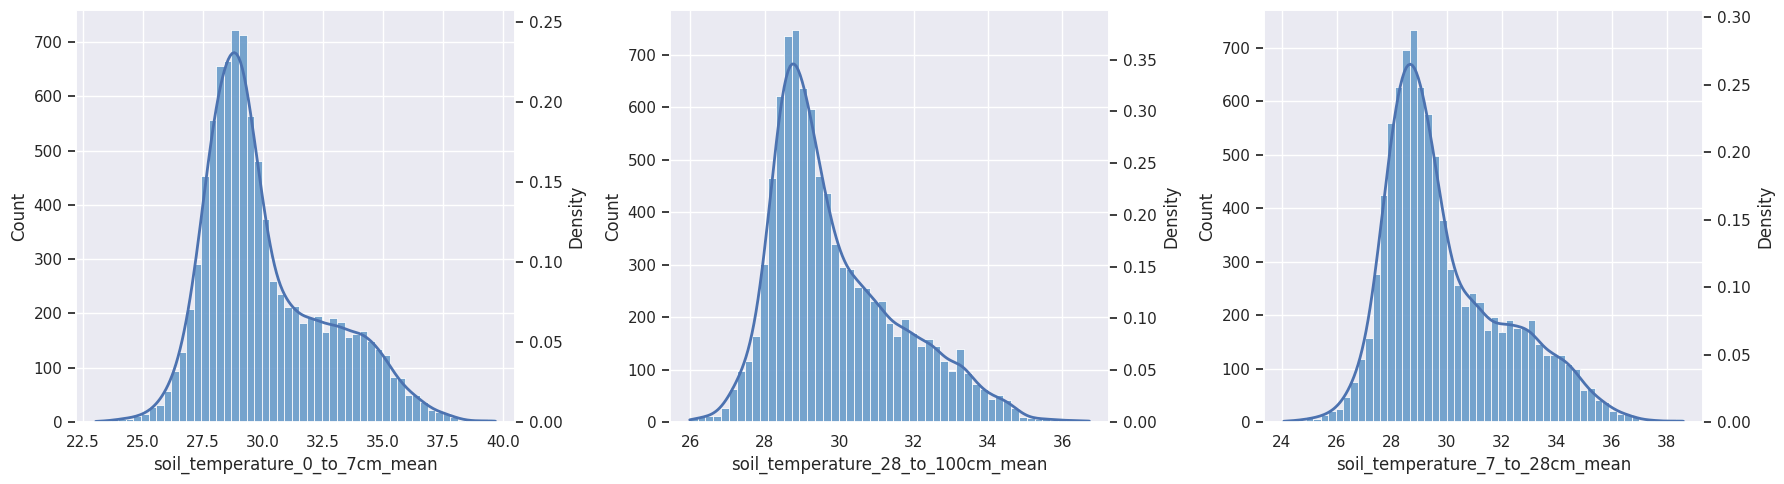

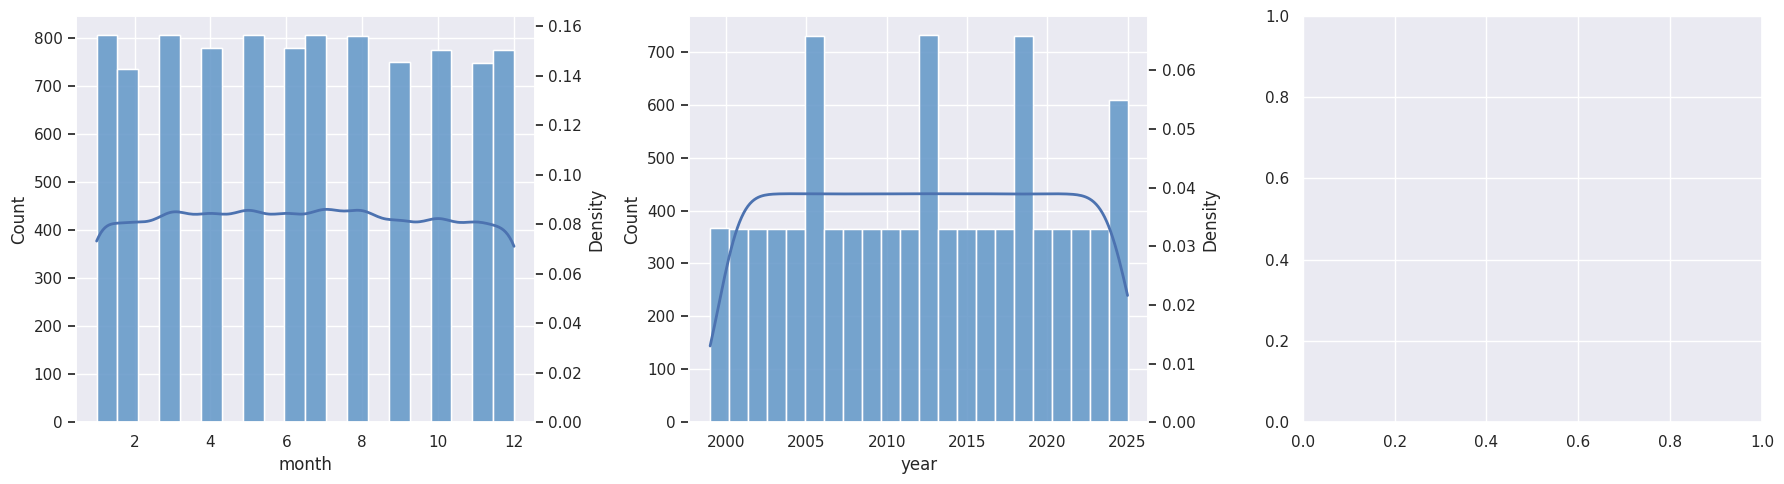

In [17]:
# Xem lại histogram của toàn bộ dữ liệu
visualize_histogram_full(data)

In [18]:
data.to_csv('open-meteo.clean.csv', index=False) 